## Crypto Prediction with LSTM: BitCoin (BTC)

- This notebook attempts to use TensorFlow Keras LSTM to predict movement in Crypto prices
- Data is pulled from the CoinApi, so it can be refreshed at any point and retrained
- 2 optimizations were used and an overall R2 score of .86 was attained

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import tensorflow as tf
from copy import deepcopy as dc
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.optimizers import Adam
import datetime as dt

import nasdaqdatalink

from api_keys import coinapi_key

In [2]:
#  https://docs.coinapi.io/market-data/rest-api/ohlcv
# Pull BTC data from coinapi

url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_BTC_USD/history?period_id=1DAY&limit=20000'
headers = {'X-CoinAPI-Key' : coinapi_key}
response = requests.get(url, headers=headers)
 
if response.status_code == 200:
    json_data = response.json()
    print(json_data)
else:
    print(f"Error: {response.status_code}")

[{'time_period_start': '2023-12-09T00:00:00.0000000Z', 'time_period_end': '2023-12-10T00:00:00.0000000Z', 'time_open': '2023-12-09T00:00:05.3930000Z', 'time_close': '2023-12-09T23:12:32.5760000Z', 'price_open': 44210, 'price_high': 44362, 'price_low': 43759, 'price_close': 43886, 'volume_traded': 856.69212832, 'trades_count': 9953}, {'time_period_start': '2023-12-08T00:00:00.0000000Z', 'time_period_end': '2023-12-09T00:00:00.0000000Z', 'time_open': '2023-12-08T00:00:10.0490000Z', 'time_close': '2023-12-08T23:59:44.6950000Z', 'price_open': 43296, 'price_high': 44729, 'price_low': 43078, 'price_close': 44193, 'volume_traded': 1701.86247505, 'trades_count': 14617}, {'time_period_start': '2023-12-07T00:00:00.0000000Z', 'time_period_end': '2023-12-08T00:00:00.0000000Z', 'time_open': '2023-12-07T00:00:04.4050000Z', 'time_close': '2023-12-07T23:59:59.4460000Z', 'price_open': 43764, 'price_high': 44044, 'price_low': 42849, 'price_close': 43291, 'volume_traded': 1537.77862126, 'trades_count': 1

In [3]:
#Convert json to pandas df
df = pd.DataFrame(json_data)

df.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-12-09T00:00:00.0000000Z,2023-12-10T00:00:00.0000000Z,2023-12-09T00:00:05.3930000Z,2023-12-09T23:12:32.5760000Z,44210.0,44362.0,43759.0,43886.0,856.692128,9953
1,2023-12-08T00:00:00.0000000Z,2023-12-09T00:00:00.0000000Z,2023-12-08T00:00:10.0490000Z,2023-12-08T23:59:44.6950000Z,43296.0,44729.0,43078.0,44193.0,1701.862475,14617
2,2023-12-07T00:00:00.0000000Z,2023-12-08T00:00:00.0000000Z,2023-12-07T00:00:04.4050000Z,2023-12-07T23:59:59.4460000Z,43764.0,44044.0,42849.0,43291.0,1537.778621,15583
3,2023-12-06T00:00:00.0000000Z,2023-12-07T00:00:00.0000000Z,2023-12-06T00:00:04.0290000Z,2023-12-06T23:59:58.2520000Z,44087.0,44282.0,43419.0,43764.0,1590.895243,17971
4,2023-12-05T00:00:00.0000000Z,2023-12-06T00:00:00.0000000Z,2023-12-05T00:00:04.8390000Z,2023-12-05T23:59:59.8540000Z,41979.0,44490.0,41415.0,44075.0,2381.718821,17747


In [4]:
#reduce df to x and y columns
data = df[["time_period_start", "price_close"]]

#rename columns
data = data.rename(columns={"time_period_start":"Date","price_close":"Close"})

#convert date to dt, refomat to yyyymmdd
data['Date'] = pd.to_datetime(data['Date']).dt.date

#json return began with most recent date, reversed for plotting/analysis
data = data.reindex(index=data.index[::-1])

#set date as index
data.set_index('Date', inplace=True)

data.head()

,Close
Date,
2011-09-13,5.97
2011-09-14,5.53
2011-09-15,5.13
2011-09-16,4.85
2011-09-17,4.87


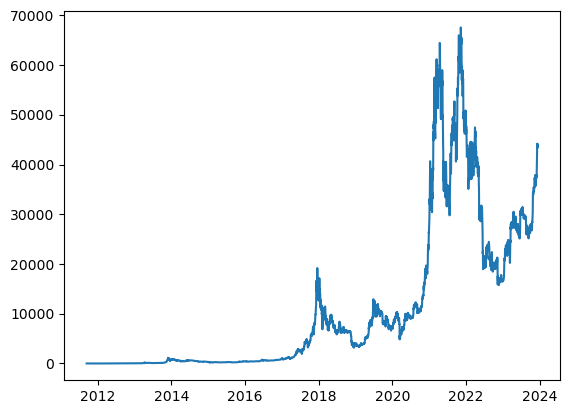

In [5]:
#plot historical amzn price
plt.plot(data)

In [6]:
# Set parameters for model

lookback = 7

split_1 = .8
split_2 = .9

In [7]:
# build lookback for lstm training
def prepare_dataframe_for_lstm(data, n_steps):
    data = dc(data)
    
    for i in range(1, n_steps+1):
        data[f'Close(t-{i})'] = data['Close'].shift(i)
        
    data.dropna(inplace=True)
    
    return data

shifted_df = prepare_dataframe_for_lstm(data, lookback)

# name date column from new index (since start date is absorbed into first x windows)
dates = shifted_df.index

#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()

#Scale data
log_transformed_data = np.log(shifted_df_as_np)



# split reference from deatures
X1 = log_transformed_data[:, 1:]
y1 = log_transformed_data[:, 0]

#flip order of windows (needs to start with most recent)

X1 = dc(np.flip(X1, axis=1))
X1


X1.shape, y1.shape, dates.shape


((4304, 7), (4304,), (4304,))

In [8]:
#Calculate split points based on previously defined variables
train_split = int(len(X1) * split_1)
test_split = int(len(X1) * split_2)

#Define spilt points for train/val/test
dates_train1, X_train1, y_train1 = dates[:train_split],X1[:train_split], y1[:train_split]
dates_val1, X_val1, y_val1 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test1, X_test1, y_test1 = dates[test_split:], X1[test_split:], y1[test_split:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((3443, 7), (3443,), (430, 7), (430,), (431, 7), (431,))

In [9]:
#Build, compile, fit LSTM model

model = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100)

Epoch 1/100


2023-12-09 18:12:36.426891: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


108/108 [==============================] - 1s 4ms/step - loss: 8.8486 - mean_absolute_error: 1.8377 - val_loss: 0.1375 - val_mean_absolute_error: 0.3303
Epoch 2/100
108/108 [==============================] - 0s 3ms/step - loss: 0.0104 - mean_absolute_error: 0.0656 - val_loss: 0.0148 - val_mean_absolute_error: 0.1005
Epoch 3/100
108/108 [==============================] - 1s 5ms/step - loss: 0.0052 - mean_absolute_error: 0.0485 - val_loss: 0.0053 - val_mean_absolute_error: 0.0577
Epoch 4/100
108/108 [==============================] - 0s 3ms/step - loss: 0.0053 - mean_absolute_error: 0.0508 - val_loss: 0.0054 - val_mean_absolute_error: 0.0583
Epoch 5/100
108/108 [==============================] - 0s 2ms/step - loss: 0.0051 - mean_absolute_error: 0.0491 - val_loss: 0.0037 - val_mean_absolute_error: 0.0474
Epoch 6/100
108/108 [==============================] - 0s 2ms/step - loss: 0.0044 - mean_absolute_error: 0.0445 - val_loss: 0.0048 - val_mean_absolute_error: 0.0558
Epoch 7/100
108/108 [=

108/108 [==============================] - 0s 844us/step


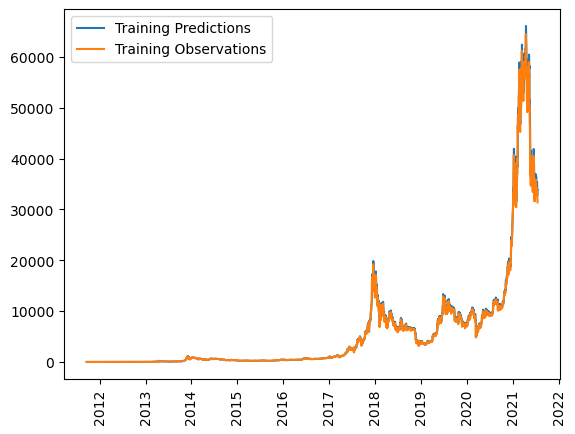

In [10]:
# Check training predictions (use np.exp to transform scaled data back to original scale)

train_predictions = model.predict(X_train1).flatten()

plt.plot(dates_train1, np.exp(train_predictions))
plt.plot(dates_train1, np.exp(y_train1))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [11]:
# Check scores for val period
score = model.evaluate(X_val1, y_val1, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.002335186814889312
Val MAE: 0.038872528821229935


14/14 [==============================] - 0s 1ms/step


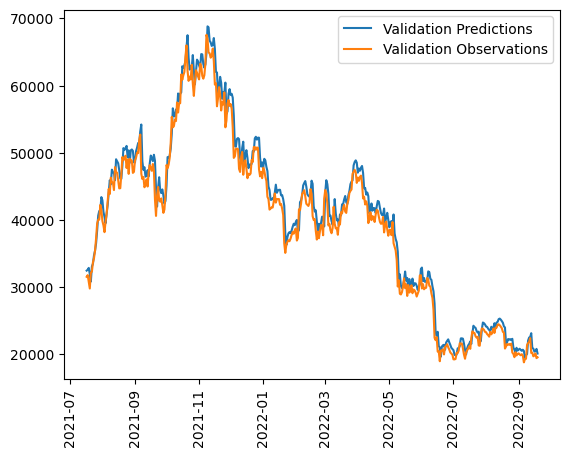

In [12]:
# graphed performance of val data in model
val_predictions = model.predict(X_val1).flatten()

plt.plot(dates_val1, np.exp(val_predictions))
plt.plot(dates_val1, np.exp(y_val1))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [13]:
score = model.evaluate(X_test1, y_test1, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0015768654411658645
Test MAE: 0.034695714712142944


14/14 [==============================] - 0s 1ms/step


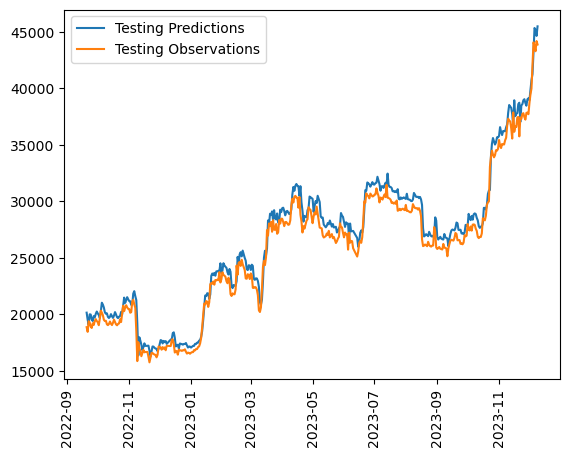

In [14]:
#check model against test data
test_predictions = model.predict(X_test1).flatten()

plt.plot(dates_test1, np.exp(test_predictions))
plt.plot(dates_test1, np.exp(y_test1))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [15]:
# Check r2 score
print('R2 Score: ', r2_score(y_test1, test_predictions))

R2 Score:  0.9720920723781395


## Optimization of the Model

- Adjust the initial data used, limited to the last 50% of the data
- Focus more on recent trends for learning
- Increase Epochs
- Slow learning rate

In [16]:
# Split is changed to begin at 50% of the dataset and continue to the end.
split_1 = .5
split_2 = .89
split_3 = .95


initial_split = int(len(X1) * split_1)
train_split = int(len(X1) * split_2)
test_split = int(len(X1) * split_3)

In [17]:
#change timeframe

dates_train2, X_train2, y_train2 = dates[initial_split:train_split],X1[initial_split:train_split], y1[initial_split:train_split]
dates_val2, X_val2, y_val2 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test2, X_test2, y_test2 = dates[test_split:], X1[test_split:], y1[test_split:]
dates_train2.shape, X_train2.shape, y_train2.shape, \
dates_val2.shape, X_val2.shape, y_val2.shape, \
dates_test2.shape, X_test2.shape, y_test2.shape

((1678,),
 (1678, 7),
 (1678,),
 (258,),
 (258, 7),
 (258,),
 (216,),
 (216, 7),
 (216,))

In [18]:
# Build, compile and fit the new model- increased epochs, smaller learning rate
model2 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model2.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=300)

Epoch 1/300
108/108 [==============================] - 1s 4ms/step - loss: 13.6962 - mean_absolute_error: 2.4438 - val_loss: 0.2538 - val_mean_absolute_error: 0.4624
Epoch 2/300
108/108 [==============================] - 0s 2ms/step - loss: 0.0115 - mean_absolute_error: 0.0653 - val_loss: 0.0195 - val_mean_absolute_error: 0.1157
Epoch 3/300
108/108 [==============================] - 0s 2ms/step - loss: 0.0050 - mean_absolute_error: 0.0475 - val_loss: 0.0063 - val_mean_absolute_error: 0.0635
Epoch 4/300
108/108 [==============================] - 0s 3ms/step - loss: 0.0051 - mean_absolute_error: 0.0493 - val_loss: 0.0118 - val_mean_absolute_error: 0.0940
Epoch 5/300
108/108 [==============================] - 0s 2ms/step - loss: 0.0052 - mean_absolute_error: 0.0505 - val_loss: 0.0042 - val_mean_absolute_error: 0.0508
Epoch 6/300
108/108 [==============================] - 0s 2ms/step - loss: 0.0042 - mean_absolute_error: 0.0431 - val_loss: 0.0041 - val_mean_absolute_error: 0.0513
Epoch 7/3

53/53 [==============================] - 0s 758us/step


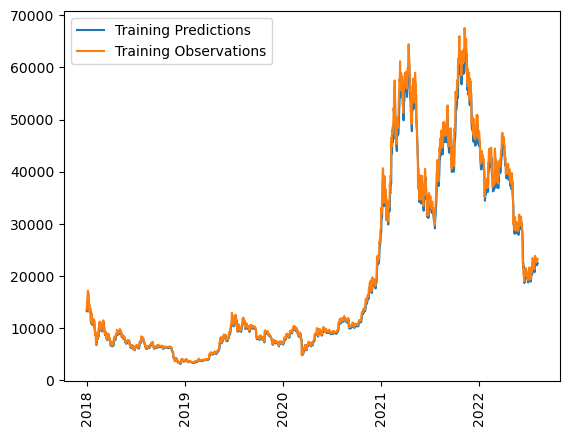

In [19]:
#Second model observations
train_predictions2 = model2.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions2))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [20]:
score = model2.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0016275248490273952
Val MAE: 0.03254154324531555


9/9 [==============================] - 0s 2ms/step


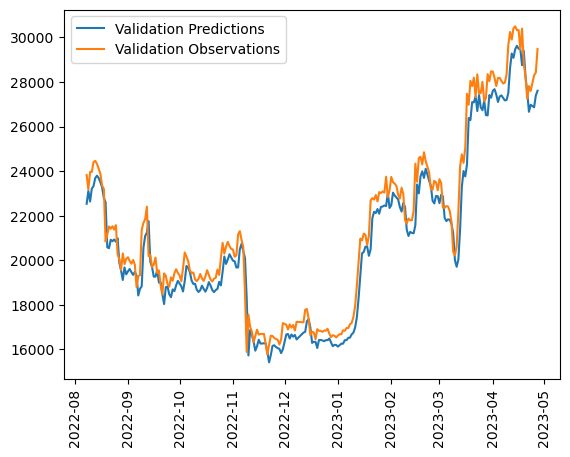

In [21]:
#Second model observations
val_predictions2 = model2.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions2))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [22]:
#MSAE Score for second model
score = model2.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0013900621561333537
Test MAE: 0.032510872930288315


In [23]:
# R2 score for second model
y_pred = model2.predict(X_test2)
print('R2 Score: ', r2_score(y_test2, y_pred))

7/7 [==============================] - 0s 2ms/step
R2 Score:  0.9218223781622354


7/7 [==============================] - 0s 2ms/step


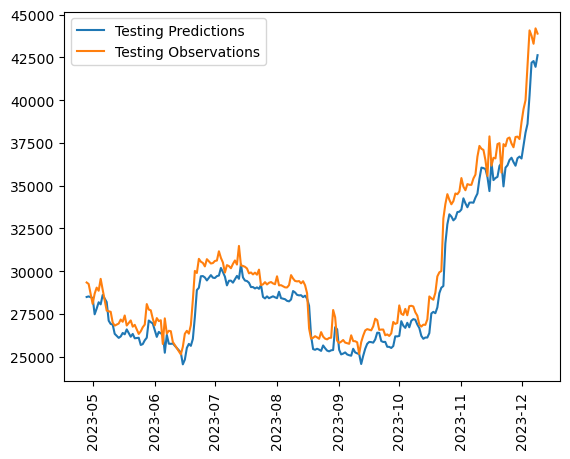

In [24]:
#Second model observations
test_predictions2 = model2.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions2))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [25]:
# Second optimization. Increased neural density, epochs
model3 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(1)])

model3.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model3.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=500)

Epoch 1/500
53/53 [==============================] - 1s 8ms/step - loss: 31.9084 - mean_absolute_error: 4.5367 - val_loss: 0.6384 - val_mean_absolute_error: 0.7801
Epoch 2/500
53/53 [==============================] - 0s 2ms/step - loss: 0.7874 - mean_absolute_error: 0.7427 - val_loss: 0.1261 - val_mean_absolute_error: 0.3127
Epoch 3/500
53/53 [==============================] - 0s 2ms/step - loss: 0.6429 - mean_absolute_error: 0.7136 - val_loss: 0.1477 - val_mean_absolute_error: 0.3490
Epoch 4/500
53/53 [==============================] - 0s 2ms/step - loss: 0.5714 - mean_absolute_error: 0.6667 - val_loss: 0.1331 - val_mean_absolute_error: 0.3341
Epoch 5/500
53/53 [==============================] - 0s 2ms/step - loss: 0.3627 - mean_absolute_error: 0.5216 - val_loss: 0.0118 - val_mean_absolute_error: 0.0848
Epoch 6/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0254 - mean_absolute_error: 0.1119 - val_loss: 0.0038 - val_mean_absolute_error: 0.0519
Epoch 7/500
53/53 [==

53/53 [==============================] - 0s 692us/step


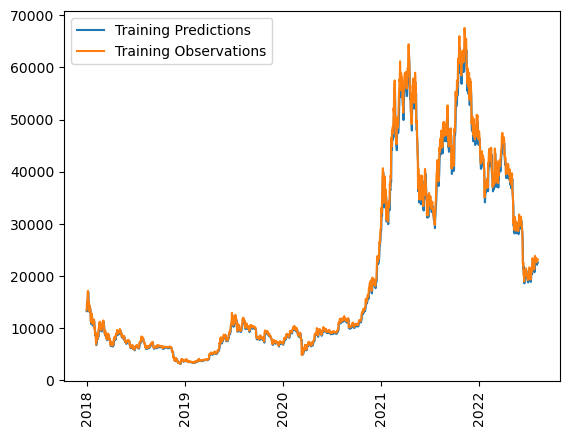

In [26]:
#Third model observations
train_predictions3 = model3.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions3))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [27]:
score = model3.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0013382919132709503
Val MAE: 0.02815362624824047


9/9 [==============================] - 0s 2ms/step


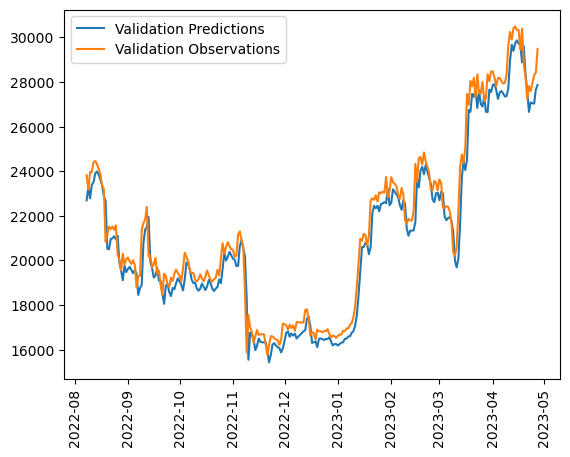

In [28]:
#Second model observations 
val_predictions3 = model3.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions3))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [29]:
# Third Model MAE score
score = model3.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.000961483281571418
Test MAE: 0.025754861533641815


7/7 [==============================] - 0s 2ms/step


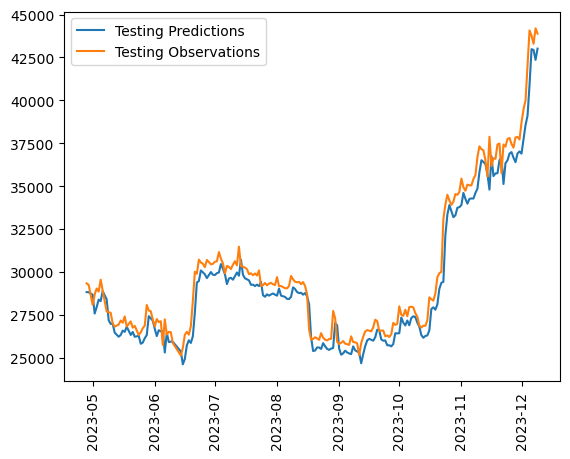

In [30]:
test_predictions3 = model3.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions3))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [31]:
# R2 score for second model

print('R2 Score: ', r2_score(y_test2, test_predictions3))

R2 Score:  0.9459257435995367


## Future Prediction
- Attempting to look ahead x days in an attempt to predict upcoming trends

In [32]:
# Initialize an array to store predictions
predictions = []
predicted_dates = []
prediction_range = 7

#create list of numbers to add to date based on date range
date_range = list(range(1, prediction_range +1))

# Use the last n_steps data points from the training set to make predictions
current_batch = (X_test2[-1])
current_reshape = current_batch.reshape(1, lookback)

# x_test = np.array(x_test)
# x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
initial_date = dates_test2[-1]

# Generate predictions for 7 days
for i in range(prediction_range): # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model.predict(current_reshape)[0,0]
    
    # Append the prediction to the list of predictions
    predictions.append(current_pred)
        

    # Update initial input for the next step
    updated_batch = np.insert(current_batch, -1, current_pred)
    
    #resize batch 
    current_batch = updated_batch[1:]
    
    #reshape batch
    current_reshape = current_batch.reshape((1, lookback))
# print(current_batch)
# print(current_reshape)

# print(X_test2)
    
for day in date_range:
    new_date = initial_date + dt.timedelta(days=day)
    predicted_dates.append(new_date
                          )
# 'predictions' contains 7-day forecast
print(predictions)

for date in predicted_dates:
    print(date)

1/1 [==============================] - 0s 9ms/step
[10.725282, 10.730676, 10.729444, 10.729105, 10.729535, 10.729758, 10.729673]
2023-12-10
2023-12-11
2023-12-12
2023-12-13
2023-12-14
2023-12-15
2023-12-16


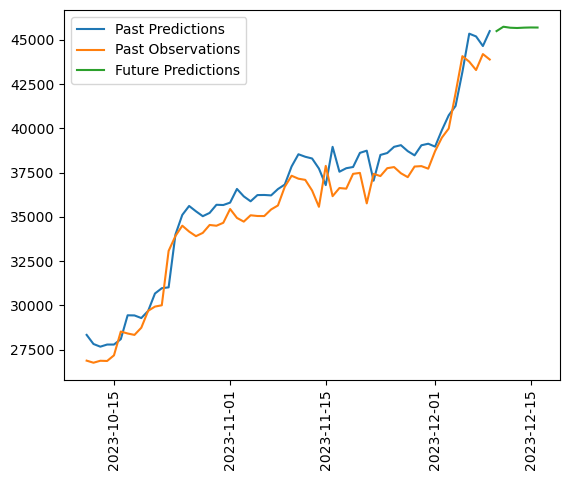

In [33]:
#Plot last 60 days of testing plus future prediction
plt.plot(dates_test2[-60:], np.exp(test_predictions[-60:]))
plt.plot(dates_test2[-60:],np.exp(y_test2[-60:]))
plt.plot(predicted_dates, np.exp(predictions))
plt.xticks(rotation=90)
plt.legend(['Past Predictions', 'Past Observations','Future Predictions'])

In [34]:
# Export model1 to HDF5 file
model.save("H5_Files/btc_7_day_1.h5")

In [35]:
# Export model2 to HDF5 file
model2.save("H5_Files/btc_7_day_2.h5")

In [36]:
# Export model to HDF5 file
model3.save("H5_Files/btc_7_day_3.h5")

In [37]:
# build output into a df for graphing in js

df = pd.DataFrame({"Date": dates_test2[-90:], "observed":np.exp(y_test2[-90:]),\
                "model_1_predicted":np.exp(test_predictions[-90:]),\
                "model_2_predicted":np.exp(test_predictions2[-90:]),\
                "model_3_predicted":np.exp(test_predictions3[-90:])})
df.set_index('Date', inplace=True)

# df2 = pd.DataFrame({"Date": predicted_dates, "future_prediction":np.exp(predictions)})
# df2.set_index('Date', inplace=True)                   
                    
# past_future_df = pd.merge(df,df2, how='outer', left_index=True, right_index=True)


df


,observed,model_1_predicted,model_2_predicted,model_3_predicted
Date,,,,
2023-09-11,25155.0,26721.990234,25144.339844,25294.394531
2023-09-12,25844.0,26044.464844,24566.603516,24672.988281
2023-09-13,26226.0,26675.267578,25044.496094,25203.832031
2023-09-14,26529.0,27139.408203,25458.111328,25674.744141
2023-09-15,26607.0,27437.148438,25747.447266,26010.013672
...,...,...,...,...
2023-12-05,44075.0,43181.695312,40258.058594,40894.761719
2023-12-06,43764.0,45346.046875,42183.605469,42981.320312
2023-12-07,43291.0,45189.382812,42281.636719,42932.695312


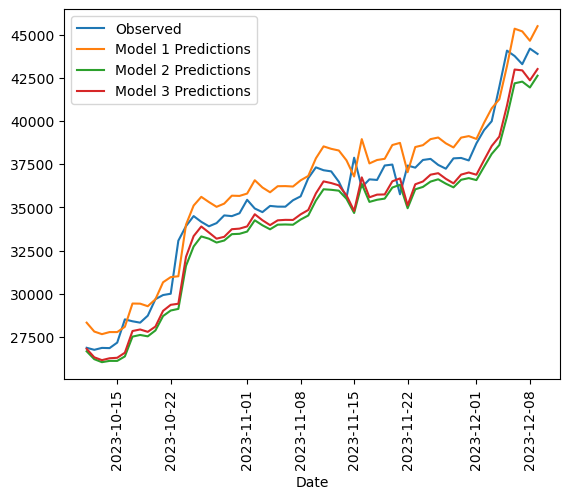

In [38]:
#Measuring each model's predictions against the test data
df[-60:].plot(use_index=True)
plt.xticks(rotation=90)

plt.legend(['Observed', 'Model 1 Predictions', 'Model 2 Predictions', \
            'Model 3 Predictions'])
plt.show()

In [39]:
#output prediction data to csv
df.to_csv('output/btc_predict.csv') 

In [40]:
#output original historical data to csv
data.to_csv('output/btc_lifetime.csv')

In [41]:
#Scores for each model

print('Model 1 R2 Score: ', r2_score(y_test1, test_predictions))
print('Model 2 R2 Score: ', r2_score(y_test2, test_predictions2))
print('Model 3 R2 Score: ', r2_score(y_test2, test_predictions3))

Model 1 R2 Score:  0.9720920723781395
Model 2 R2 Score:  0.9218223781622354
Model 3 R2 Score:  0.9459257435995367
